In [2]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # activation functions
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

### Set Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [4]:
input_size = 28
sequence_length = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

### Load Data

In [5]:
train_dataset = datasets.MNIST(root='dataset/', 
                               train=True, 
                               transform=transforms.ToTensor(), 
                               download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', 
                               train=False, 
                               transform=transforms.ToTensor(), 
                               download=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Create a RNN

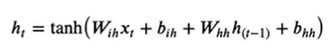

In [10]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # batch_first=> keeps the batch_size as first dim/axis
    # Input => batch_size * time_seq * features
    self.fc = nn.Linear(hidden_size*sequence_length, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    # Forward Prop
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [19]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # batch_first=> keeps the batch_size as first dim/axis
    # Input => batch_size * time_seq * features
    self.fc = nn.Linear(hidden_size*sequence_length, num_classes)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    # Forward Prop
    out, _ = self.lstm(x, (h0, c0))
    out = out.reshape(out.shape[0], -1)
    # out = self.fc(out[:,-1,:]) # all training examples, last hidden state, all features
    out = self.fc(out)
    return out

### Initialize the Model

In [20]:
# model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

### Loss and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Remember to give model parameters here

### Training the Model

In [21]:
for epoch in tqdm(range(num_epochs)):
  for ind, (data, target) in enumerate(train_loader):
    data = data.to(device=device).squeeze(1)
    target = target.to(device=device)
    
    # forward
    scores = model(data)
    loss = criterion(scores, target)

    # backward
    optimizer.zero_grad() # set all the gradients to 0 for each batch
    loss.backward()

    # gradient descent or adam step - updates the parameters
    optimizer.step()

  print(f"Epoch {epoch+1} is done")

 20%|██        | 1/5 [03:34<14:19, 214.76s/it]

Epoch 1 is done


 40%|████      | 2/5 [07:08<10:42, 214.08s/it]

Epoch 2 is done


 60%|██████    | 3/5 [10:42<07:08, 214.20s/it]

Epoch 3 is done


 80%|████████  | 4/5 [14:16<03:34, 214.07s/it]

Epoch 4 is done


100%|██████████| 5/5 [17:49<00:00, 213.98s/it]

Epoch 5 is done


In [22]:
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval() # Let the model know that this is evaluation mode

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device).squeeze(1)
      y = y.to(device=device)

      scores = model(x)
      
      # Which class has the max value
      _, pred = scores.max(dim=1)
      num_correct += (pred == y).sum()
      num_samples += pred.size(0) # 64

    print(f"Got {num_correct} / {num_samples} with accuracy {(float(num_correct)/float(num_samples)*100):.2f}%")

In [23]:
check_accuracy(test_loader, model)

Got 954 / 10000 with accuracy 9.54%
